In [1]:
import sys
sys.path.insert(0, "/home/storage/hans/jax_reco")

import jax.numpy as jnp
from jax.scipy import optimize
import jax
jax.config.update("jax_enable_x64", True)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sys, os

from lib.simdata_i3 import I3SimHandlerFtr
from lib.plotting import plot_event, adjust_plot_1d
from lib.geo import center_track_pos_and_time_based_on_data

from lib.network import get_network_eval_v_fn

from dom_track_eval import get_eval_network_doms_and_track
from time_sampler import sample_times_clean

from palettable.cubehelix import Cubehelix
cx =Cubehelix.make(start=0.3, rotation=-0.5, n=16, reverse=False, gamma=1.0,
                           max_light=1.0,max_sat=0.5, min_sat=1.4).get_mpl_colormap()

2024-06-03 14:04:48.480407: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


muon energy: 2.1 TeV
n_doms 29


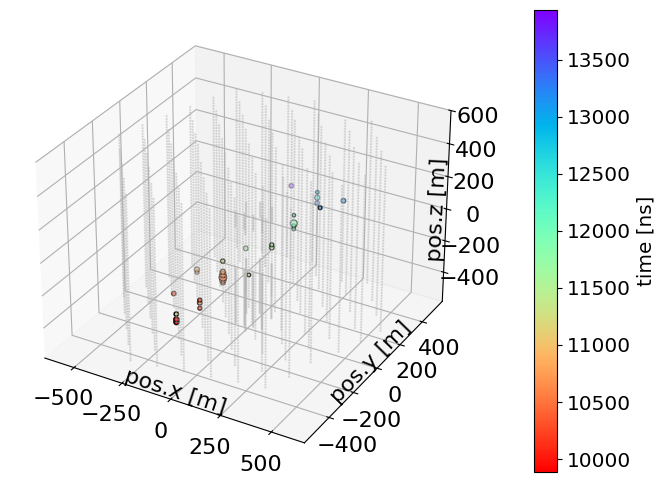

In [2]:
# Event Index.
event_index = 0

# Get network and eval logic.
eval_network_v = get_network_eval_v_fn(bpath='/home/storage/hans/jax_reco/data/network')
eval_network_doms_and_track = get_eval_network_doms_and_track(eval_network_v)

# Get an IceCube event.
bp = '/home/storage2/hans/i3files/21217'
sim_handler = I3SimHandlerFtr(os.path.join(bp, 'meta_ds_21217_from_35000_to_53530.ftr'),
                              os.path.join(bp, 'pulses_ds_21217_from_35000_to_53530.ftr'),
                              '/home/storage/hans/jax_reco/data/icecube/detector_geometry.csv')

meta, pulses = sim_handler.get_event_data(event_index)
print(f"muon energy: {meta['muon_energy_at_detector']/1.e3:.1f} TeV")

# Get dom locations, first hit times, and total charges (for each dom).
event_data = sim_handler.get_per_dom_summary_from_sim_data(meta, pulses)

print("n_doms", len(event_data))

# Produce and save an event view.
plot_event(event_data, geo=sim_handler.geo)

In [3]:
track_pos = jnp.array([meta['muon_pos_x'], meta['muon_pos_y'], meta['muon_pos_z']])
track_time = meta['muon_time']
track_zenith = meta['muon_zenith']
track_azimuth = meta['muon_azimuth']
track_src = jnp.array([track_zenith, track_azimuth])

print("old track vertex:", track_pos)
centered_track_pos, centered_track_time = center_track_pos_and_time_based_on_data(event_data, track_pos, track_time, track_src)
print("new track vertex:", centered_track_pos)

old track vertex: [-1277.51128861 -1390.39564543 -1675.98024553]
new track vertex: [ -53.74394146  162.12452256 -233.73599134]


In [4]:
# Create some n_photons from qtot (by rounding up).
n_photons = np.round(event_data['charge'].to_numpy()+0.5)

# Combine into single data tensor for fitting.
fitting_event_data = jnp.column_stack([
                                        jnp.array(event_data[['x', 'y', 'z', 'time']].to_numpy()),
                                        jnp.array(n_photons)
                                   ])


In [5]:
from lib.cgamma import c_multi_gamma_prob_v

In [24]:


def get_neg_c_triple_gamma_llh_const_vertex(eval_network_doms_and_track_fn, 
                                            eps=jnp.float64(1.e-20), 
                                            dtype=jnp.float64):

    @jax.jit
    def neg_c_triple_gamma_llh_const_vertex(track_direction, 
                                            track_vertex, 
                                            track_time, 
                                            event_data):
        dom_pos = event_data[:, :3]
        first_hit_times = event_data[:, 3]
        logits, av, bv, geo_time = eval_network_doms_and_track_fn(dom_pos, track_vertex, track_direction)

        mix_probs = jax.nn.softmax(logits)
        delay_time = first_hit_times - (geo_time + track_time)
    
        sigma = 3.0
        delta = 10.0
        return -2.0 * jnp.sum(jnp.log(c_multi_gamma_prob_v(delay_time, 
                                                           mix_probs,
                                                           av,
                                                           bv,
                                                           sigma,
                                                           delta)))

    return neg_c_triple_gamma_llh_const_vertex

In [25]:
neg_llh = get_neg_c_triple_gamma_llh_const_vertex(eval_network_doms_and_track)

@jax.jit
def neg_llh_vertex(track_vertex, track_time, track_direction, event_data):
    return neg_llh(track_direction, track_vertex, track_time, event_data)

In [26]:
print(centered_track_pos)

[ -53.74394146  162.12452256 -233.73599134]


In [27]:
# And do a minimization.
@jax.jit
def minimize_bfgs(track_dir, x0, track_time, data):
    return optimize.minimize(neg_llh_vertex, 
                             x0, 
                             args=(track_time,
                                   track_dir,
                                   data), 
                             method="BFGS", 
                             tol=1.e-3).fun

result_bfgs = minimize_bfgs(track_src, centered_track_pos, centered_track_time, fitting_event_data)
print(result_bfgs)

345.2612345660149


In [10]:
# And do a minimization.
@jax.jit
def minimize_lbfgs(track_dir, x0, track_time, data):
    return optimize.minimize(neg_llh_vertex, 
                             x0, 
                             args=(track_time,
                                   track_dir,
                                   data),  
                             method="l-bfgs-experimental-do-not-rely-on-this", 
                             tol=1.e-5).fun

result_lbfgs = minimize_lbfgs(track_src, centered_track_pos, centered_track_time, fitting_event_data)
print(result_lbfgs)

345.2217617362052


In [19]:
#%timeit minimize_lbfgs(track_src, centered_track_pos)

181 ms ± 19.3 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [13]:
profile_w_bfgs = jax.jit(jax.vmap(minimize_bfgs, (0, None, None, None), 0))

In [12]:
#profile_w_lbfgs = jax.jit(jax.vmap(minimize_lbfgs, (0, None, None, None), 0))

In [15]:
print(logls)

[352.39127258 346.91033256 346.08038534 347.64209466 351.87068685
 346.50778029 344.62607909 345.34328423 354.81793527 347.43775308
 344.88556259 344.61692842 354.62010046 349.7234178  347.0479207
 346.47587048]


In [23]:
# test vectorization
n_eval = 14
zenith = np.linspace(track_src[0]-0.01, track_src[0]+0.01, n_eval)
azimuth = np.linspace(track_src[1]-0.01, track_src[1]+0.01, n_eval)
X, Y = np.meshgrid(zenith, azimuth)

init_dirs = np.column_stack([X.flatten(), Y.flatten()])
logls = profile_w_bfgs(init_dirs, centered_track_pos, centered_track_time, fitting_event_data)

In [16]:
#%timeit profile_w_bfgs(init_dirs, centered_track_pos, centered_track_time, fitting_event_data)

8.84 s ± 944 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [28]:
def GreatCircleDistance(azi_1, zen_1, azi_2, zen_2):
        ra_1 = azi_1
        ra_2 = azi_2
        dec_1 = np.pi/2.0 - zen_1
        dec_2 = np.pi/2.0 - zen_2
        '''Compute the great circle distance between two events'''
        '''All coordinates must be given in radians'''
        delta_dec = np.abs(dec_1 - dec_2)
        delta_ra = np.abs(ra_1 - ra_2)
        x = (np.sin(delta_dec / 2.))**2. + np.cos(dec_1) *\
            np.cos(dec_2) * (np.sin(delta_ra / 2.))**2.
        return 2. * np.arcsin(np.sqrt(x))

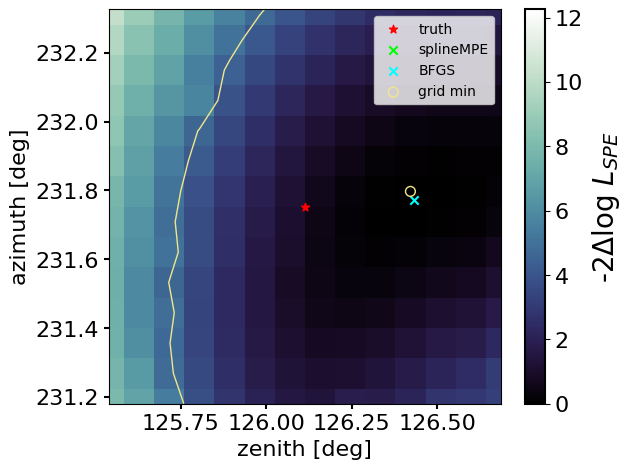

TriplePandelSPE: 0.31055544949670644
SplineMPE: 1.3853546375668764


In [30]:
# And plot likelihood space.
'''
n_eval = 20
zenith = np.linspace(track_src[0]-0.02, track_src[0]+0.02, n_eval)
azimuth = np.linspace(track_src[1]-0.02, track_src[1]+0.02, n_eval)
X, Y = np.meshgrid(zenith, azimuth)

init_dirs = np.column_stack([X.flatten(), Y.flatten()])
logls = neg_llh_v(init_dirs, centered_track_pos, centered_track_time, fitting_event_data)
'''

logls = logls.reshape(X.shape)

fig, ax = plt.subplots()
min_logl = np.amin(logls)
delta_logl = logls - np.amin(logls)
pc = ax.pcolormesh(np.rad2deg(X), np.rad2deg(Y), delta_logl, vmin=0, vmax=np.min([25, 1.2*np.amax(delta_logl)]), shading='auto', cmap=cx)
cbar = fig.colorbar(pc)
cbar.ax.tick_params(labelsize=16)
cbar.ax.get_yaxis().labelpad = 5
cbar.set_label("-2$\\Delta$log $L_{SPE}$", fontsize=20)
cbar.outline.set_linewidth(1.5)

ax.set_xlabel("zenith [deg]", fontsize=16)
ax.set_ylabel("azimuth [deg]", fontsize=16)
ax.set_xlim(np.rad2deg([track_src[0]-0.01, track_src[0]+0.01]))
ax.set_ylim(np.rad2deg([track_src[1]-0.01, track_src[1]+0.01]))
ax.tick_params(axis='both', which='both', width=1.5, colors='0.0', labelsize=16)

ax.scatter(np.rad2deg(track_src[0]), np.rad2deg(track_src[1]), marker="*", color='red', label="truth", zorder=200)

smpe_zenith = meta['spline_mpe_zenith']
smpe_azimuth = meta['spline_mpe_azimuth']
ax.scatter(np.rad2deg([smpe_zenith]), np.rad2deg([smpe_azimuth]), marker="x", color='lime', label='splineMPE')

#zenith = result_bfgs.x[0]
#azimuth = result_bfgs.x[1]
#ax.scatter(np.rad2deg(zenith), np.rad2deg(azimuth), marker='^', color='cyan', label='BFGS')

#zenith = result_lbfgs.x[0]
#azimuth = result_lbfgs.x[1]
#ax.scatter(np.rad2deg(zenith), np.rad2deg(azimuth), marker='v', color='magenta', label='L-BFGS')

ax.scatter(np.rad2deg(2.20665164), np.rad2deg(4.04518655), marker='x', color='cyan', label='BFGS')
# generate contours
contours = [4.61]
ix1, ix2 = np.where(delta_logl==0)
ax.scatter(np.rad2deg([X[ix1, ix2]]), np.rad2deg([Y[ix1, ix2]]), s=50, marker='o', facecolors='none', edgecolors='khaki', zorder=100., label='grid min')
ct = plt.contour(np.rad2deg(X), np.rad2deg(Y), delta_logl, levels=contours, linestyles=['solid'], colors=['khaki'], linewidths=1.0)

plt.legend()
plt.tight_layout()
plt.show()


print("TriplePandelSPE:", np.squeeze(np.rad2deg(GreatCircleDistance(track_src[1], track_src[0], Y[ix1, ix2], X[ix1, ix2]))))
print("SplineMPE:", np.rad2deg(GreatCircleDistance(track_src[1], track_src[0], smpe_azimuth, smpe_zenith)))

In [7]:
neg_llh = get_neg_c_triple_gamma_llh_const_vertex(eval_network_doms_and_track)

@jax.jit
def neg_llh_vertex(track_vertex, track_time, track_direction, event_data):
    return neg_llh(track_direction, track_vertex, track_time, event_data)

In [8]:
# And do a minimization.
@jax.jit
def minimize_bfgs(track_dir, x0, track_time, data):
    return optimize.minimize(neg_llh_vertex, 
                             x0, 
                             args=(track_time,
                                   track_dir,
                                   data), 
                             method="BFGS", 
                             tol=1.e-3).fun

result_bfgs = minimize_bfgs(track_src, centered_track_pos, centered_track_time, fitting_event_data)
print(result_bfgs)

345.2612345660149


In [9]:
profile_w_bfgs = jax.jit(jax.vmap(minimize_bfgs, (0, None, None, None), 0))

In [10]:
# test vectorization
n_eval = 4
zenith = np.linspace(track_src[0]-0.01, track_src[0]+0.01, n_eval)
azimuth = np.linspace(track_src[1]-0.01, track_src[1]+0.01, n_eval)
X, Y = np.meshgrid(zenith, azimuth)

init_dirs = np.column_stack([X.flatten(), Y.flatten()])
logls = profile_w_bfgs(init_dirs, centered_track_pos, centered_track_time, fitting_event_data)

In [11]:
%timeit profile_w_bfgs(init_dirs, centered_track_pos, centered_track_time, fitting_event_data)

8.8 s ± 3.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [31]:
neg_llh = get_neg_c_triple_gamma_llh_const_vertex(eval_network_doms_and_track)

@jax.jit
def neg_llh_5D(x, track_time, event_data):
    track_direction = x[:2]
    track_vertex = x[2:]
    return neg_llh(track_direction, track_vertex, track_time, event_data)

In [32]:
# And do a minimization.
@jax.jit
def minimize_bfgs_5D(x0, track_time, data):
    return optimize.minimize(neg_llh_5D, 
                             x0, 
                             args=(track_time,
                                   data), 
                             method="BFGS", 
                             tol=1.e-3)

In [33]:
result_bfgs = minimize_bfgs_5D(jnp.concatenate([track_src, centered_track_pos]), 
                               centered_track_time, 
                               fitting_event_data)
print(result_bfgs)

OptimizeResults(x=Array([   2.20665164,    4.04518655,  -54.03553714,  162.6675879 ,
       -233.40931794], dtype=float64), success=Array(False, dtype=bool), status=Array(3, dtype=int64, weak_type=True), fun=Array(344.40412583, dtype=float64), jac=Array([-3.19560612e-03, -1.31979524e-03, -3.34684373e-06,  3.21153983e-06,
        1.99245484e-05], dtype=float64), hess_inv=Array([[ 4.57885025e-05,  1.95087249e-05, -7.51473882e-03,
        -1.96164195e-03,  6.15164591e-03],
       [ 1.95087249e-05,  2.68929905e-05, -2.72222865e-03,
         3.35951511e-04,  4.01029784e-03],
       [-7.51473882e-03, -2.72222865e-03,  1.70477182e+00,
         4.00707948e-01, -1.08794172e+00],
       [-1.96164195e-03,  3.35951511e-04,  4.00707948e-01,
         3.48155935e-01, -2.57448907e-01],
       [ 6.15164591e-03,  4.01029784e-03, -1.08794172e+00,
        -2.57448907e-01,  1.23342343e+00]], dtype=float64), nfev=Array(67, dtype=int64, weak_type=True), njev=Array(67, dtype=int64, weak_type=True), nit=Array(

In [18]:
print(neg_llh(track_src, centered_track_pos, centered_track_time, fitting_event_data))

347.80020840454387


In [36]:
%timeit minimize_bfgs_5D(jnp.concatenate([track_src, centered_track_pos]), centered_track_time, fitting_event_data)

1.25 s ± 321 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
# 1.25s for 5D minimization